In [1]:
import os
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

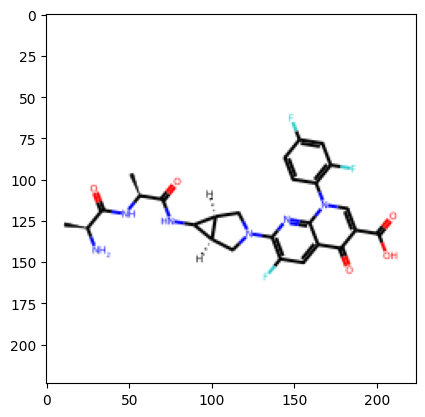

In [2]:
# Load sucrose from SMILES
smile_example = "C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN(C2)C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F)N"
mol = Chem.MolFromSmiles(smile_example)

# Draw 3D structure
img = Draw.MolToImage(mol, size=(224, 224))
plt.imshow(img)

# Save image
img.save("data_smiles/sucrose.png")

n1(-c2c(F)cc(F)cc2)cc(C(O)=O)c(=O)c2c1nc(N1C[C@H]3C(NC([C@@H](NC(=O)[C@@H](N)C)C)=O)[C@H]3C1)c(F)c2
n1(-c2ccc(F)cc2F)c2c(c(=O)c(C(O)=O)c1)cc(F)c(N1C[C@@H]3C(NC([C@@H](NC(=O)[C@H](C)N)C)=O)[C@@H]3C1)n2
c1(N2C[C@H]3C(NC(=O)[C@@H](NC(=O)[C@H](C)N)C)[C@H]3C2)c(F)cc2c(n(-c3c(F)cc(F)cc3)cc(C(=O)O)c2=O)n1
c1(F)cc(F)c(-n2cc(C(=O)O)c(=O)c3cc(F)c(N4C[C@@H]5C(NC(=O)[C@@H](NC([C@@H](N)C)=O)C)[C@@H]5C4)nc23)cc1
N(C(=O)[C@@H](NC([C@H](C)N)=O)C)C1[C@@H]2[C@H]1CN(c1c(F)cc3c(n(-c4ccc(F)cc4F)cc(C(O)=O)c3=O)n1)C2


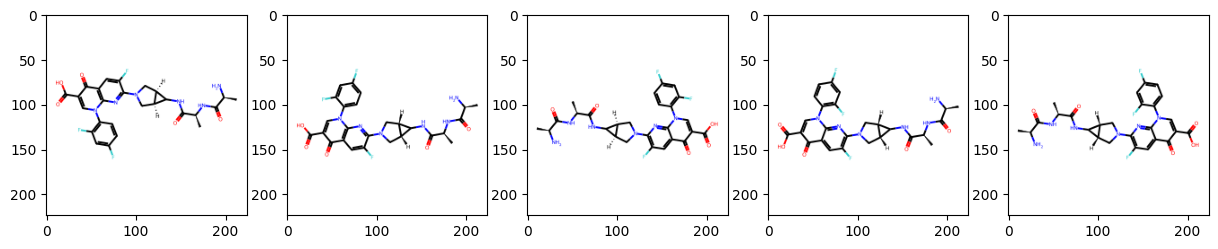

In [3]:
# data augmentation
from utils.SmilesEnumeration import SmilesEnumerator

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
sme = SmilesEnumerator()
for i in range(5):
    example_randomized = sme.randomize_smiles(smile_example)
    print(example_randomized)

    mol = Chem.MolFromSmiles(example_randomized)

    # Draw 3D structure
    img = Draw.MolToImage(mol, size=(224, 224))
    axes[i].imshow(img)

# Generate images

In [2]:
# load training data
import pandas as pd

pd_data_train = pd.read_csv("data_smiles/Training_Group.csv")
print(pd_data_train.shape)
pd_data_train.head()

(1241, 2)


,Smiles,Liver
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity
3,O(CCO)CC,Hepatotoxicity
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity


In [3]:
pd_data_test = pd.read_csv("data_smiles/Testing_Group.csv")
print(pd_data_test.shape)
pd_data_test.head()

(286, 2)


,Smiles,Liver
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity


In [4]:
# Example class definition for SmilesEnumerator (ensure you have the actual implementation)
class SmilesEnumerator:
    def randomize_smiles(self, smile):
        # Example placeholder, implement this method to randomize SMILES
        return smile

# Initialize SmilesEnumerator
sme = SmilesEnumerator()

def process_smiles_images(data, folder_name, augment=False, augment_times=5):
    """
    Process SMILES strings, generate images, and save mappings.

    Args:
        data (pd.DataFrame): DataFrame containing SMILES and class labels.
        folder_name (str): Directory name where images will be saved (e.g., 'Training_Group', 'Testing_Group').
        augment (bool): Whether to apply SMILES augmentation. Default is False.
        augment_times (int): Number of augmentations to generate. Default is 5.
    
    Returns:
        smiles_mapping (list): List of dictionaries mapping SMILES to filenames.
    """
    smiles_mapping = []

    for i, row in data.iterrows():
        smile = row["Smiles"]
        class_label = row["Liver"]

        # Create directories if they don't exist
        os.makedirs(f"data_smiles/{folder_name}/{class_label}", exist_ok=True)
        if augment:
            os.makedirs(f"data_smiles/{folder_name}_Augmented/{class_label}", exist_ok=True)

          

        # Apply augmentation if enabled
        if augment:
            # Generate a unique filename based on the hash of the SMILES string
            smile_normalized = str(hash(smile) % ((1 << 31) - 1))

            # Create an RDKit molecule object from SMILES and save the image
            mol = Chem.MolFromSmiles(smile)
            img = Draw.MolToImage(mol, size=(224, 224))
            img.save(f"data_smiles/{folder_name}_Augmented/{class_label}/{smile_normalized}.png")      

            # Store the mapping (original SMILES → filename)
            smiles_mapping.append({
                "smiles": smile,
                "class_label": class_label,
                "filename": f"{class_label}/{smile_normalized}.png",
                "folder": f"{folder_name}_Augmented"
            })
            
            for j in range(augment_times):
                example_randomized = sme.randomize_smiles(smile)
                mol = Chem.MolFromSmiles(example_randomized)
                img = Draw.MolToImage(mol, size=(224, 224))
                img.save(f"data_smiles/{folder_name}_Augmented/{class_label}/{smile_normalized}_{j}.png")

                # Store the mapping for augmented images
                smiles_mapping.append({
                    "smiles": example_randomized,
                    "class_label": class_label,
                    "filename": f"{class_label}/{smile_normalized}_{j}.png",
                    "folder": f"{folder_name}_Augmented"
                })

        else:
            # Generate a unique filename based on the hash of the SMILES string
            smile_normalized = str(hash(smile) % ((1 << 31) - 1))

            # Create an RDKit molecule object from SMILES and save the image
            mol = Chem.MolFromSmiles(smile)
            img = Draw.MolToImage(mol, size=(224, 224))
            img.save(f"data_smiles/{folder_name}/{class_label}/{smile_normalized}.png")      
            
            # Store the mapping (original SMILES → filename)
            smiles_mapping.append({
                "smiles": smile,
                "class_label": class_label,
                "filename": f"{class_label}/{smile_normalized}.png",
                "folder": folder_name
            })

    return smiles_mapping

In [5]:
# Process training data
train_smiles_mapping = process_smiles_images(pd_data_train, folder_name="Training_Group", augment=True, augment_times=25)

# Save the combined SMILES to filename mapping to a CSV file
train_mapping_df = pd.DataFrame(train_smiles_mapping)
train_mapping_df.to_csv("data_smiles/training_smiles_filename_mapping_x25.csv", index=False)

In [6]:
# Process testing data (usually no augmentation for testing data)
test_smiles_mapping = process_smiles_images(pd_data_test, folder_name="Testing_Group")

# Save the combined SMILES to filename mapping to a CSV file
test_mapping_df = pd.DataFrame(test_smiles_mapping)
test_mapping_df.to_csv("data_smiles/testing_smiles_filename_mapping_x25.csv", index=False)

In [15]:
# Load the mapping CSV
mapping_df = pd.read_csv("data_smiles/testing_smiles_filename_mapping.csv")

# Example filename to search for (e.g., '12345678.png')
filename_to_search = "Hepatotoxicity/772554834.png"

# Find the corresponding SMILES
smiles_row = mapping_df[mapping_df['filename'] == filename_to_search]

if not smiles_row.empty:
    original_smiles = smiles_row.iloc[0]['smiles']
    print(f"Original SMILES: {original_smiles}")
else:
    print(f"No SMILES found for the filename {filename_to_search}")


Original SMILES: C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl


# Calculate normalize mean and std

In [36]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

In [37]:
def calculate_mean_std_multiple_dirs(directories):
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)
    total_pixels = 0

    for image_folder in directories:
        image_files = [
            os.path.join(image_folder, f)
            for f in os.listdir(image_folder)
            if f.endswith(".png")
        ]

        for img_file in tqdm(image_files, desc=f"Processing {image_folder}"):
            img = Image.open(img_file).convert("RGB")
            img_array = np.array(img) / 255.0

            channel_sum += img_array.sum(axis=(0, 1))
            channel_sum_squared += (img_array**2).sum(axis=(0, 1))
            total_pixels += img_array.shape[0] * img_array.shape[1]

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sum_squared / total_pixels - mean**2)

    return mean, std

In [39]:
# Directories for both training datasets
train_dirs = ["data_smiles/Training_Group", "data_smiles/Training_Group_Augmented"]

# Calculate mean and std across multiple directories
mean, std = calculate_mean_std_multiple_dirs(train_dirs)
print(f"Mean: {mean}:.3f")
print(f"Std: {std}:.3f")

Processing data_smiles/Training_Group_Augmented: 100%|██████████| 6205/6205 [00:13<00:00, 469.68it/s]

Mean: [0.97504467 0.97167537 0.97449775]
Std: [0.1405735  0.14853673 0.14202789]


# Generate ECFP features

In [14]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

In [17]:
# Load sucrose from SMILES
smile_example = "C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN(C2)C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F)N"
mol_example = Chem.MolFromSmiles(smile_example)
ecfp_example = AllChem.GetMorganFingerprintAsBitVect(mol_example, 2, nBits=1024)
ecfp_example = np.array(ecfp_example)
ecfp_example.mean()

[05:28:05] DEPRECATION WARNING: please use MorganGenerator


0.064453125

In [18]:
# load training data
import pandas as pd

pd_data_train = pd.read_csv("data_smiles/Training_Group.csv")
print(pd_data_train.shape)
pd_data_train.head()

(1241, 2)


,Smiles,Liver
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity
3,O(CCO)CC,Hepatotoxicity
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity


In [19]:
pd_data_test = pd.read_csv("data_smiles/Testing_Group.csv")
print(pd_data_test.shape)
pd_data_test.head()

(286, 2)


,Smiles,Liver
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity


In [23]:
# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))


# Convert SMILES to RDKit molecules
def convert_to_molecule(df):
    df["molecule"] = df["Smiles"].apply(Chem.MolFromSmiles)
    df["ecfp"] = df["molecule"].apply(generate_ecfp)
    df = df[["Liver", "ecfp"]]
    df = df.rename(columns={"Liver": "Class"})

    # Expand the ecfp list into separate columns
    ecfp_df = pd.DataFrame(df["ecfp"].tolist(), index=df.index)

    # Rename columns to ecfp1, ecfp2, ..., ecfpN
    ecfp_df.columns = [f"ecfp{i+1}" for i in range(ecfp_df.shape[1])]

    # Concatenate the original dataframe with the new expanded columns
    result_df = pd.concat([df.drop(columns="ecfp"), ecfp_df], axis=1)
    return result_df


df_train = convert_to_molecule(pd_data_train)
df_test = convert_to_molecule(pd_data_test)

# Save ECFP data
df_train.to_csv("data/Training_Group_ECFP.csv", index=False)
df_test.to_csv("data/Testing_Group_ECFP.csv", index=False)

[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerator
[05:36:35] DEPRECATION WARNING: please use MorganGenerat

# Generate PaDel augmented

In [1]:
import pandas as pd
from padelpy import padeldescriptor, from_smiles

In [2]:
# calculate molecular descriptors for propane
descriptors = from_smiles("CCC", fingerprints=True, descriptors=True)
print(len(descriptors))
descriptors

2756


{'nAcid': '0',
 'ALogP': '-0.1853999999999998',
 'ALogp2': '0.034373159999999923',
 'AMR': '14.709',
 'apol': '10.614344000000001',
 'naAromAtom': '0',
 'nAromBond': '0',
 'nAtom': '11',
 'nHeavyAtom': '3',
 'nH': '8',
 'nB': '0',
 'nC': '3',
 'nN': '0',
 'nO': '0',
 'nS': '0',
 'nP': '0',
 'nF': '0.0',
 'nCl': '0.0',
 'nBr': '0.0',
 'nI': '0.0',
 'nX': '0.0',
 'ATS0m': '440.92087500000014',
 'ATS1m': '385.3849459999999',
 'ATS2m': '272.44744900000023',
 'ATS3m': '84.835296',
 'ATS4m': '9.144576',
 'ATS5m': '0.0',
 'ATS6m': '0.0',
 'ATS7m': '0.0',
 'ATS8m': '0.0',
 'ATS0v': '1519.2206606954308',
 'ATS1v': '1764.9267344628088',
 'ATS2v': '1788.4692764710278',
 'ATS3v': '1061.4246313942745',
 'ATS4v': '279.75369987837234',
 'ATS5v': '0.0',
 'ATS6v': '0.0',
 'ATS7v': '0.0',
 'ATS8v': '0.0',
 'ATS0e': '76.36925999999998',
 'ATS1e': '72.02208800000001',
 'ATS2e': '125.74608399999998',
 'ATS3e': '123.32735999999997',
 'ATS4e': '60.46617599999999',
 'ATS5e': '0.0',
 'ATS6e': '0.0',
 'ATS7e': 

In [3]:
padeldescriptor(
    mol_dir="example.smi",
    d_file="example.csv",
    d_2d=True,
    d_3d=True,
    fingerprints=True,
    retainorder=True,
    convert3d=True,
    detectaromaticity=True,
    removesalt=True,
    retain3d=True,
    standardizenitro=True,
    standardizetautomers=True,
)

In [6]:
pd_padel = pd.read_csv("example.csv")
pd_padel.head()

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_example,0,-0.1854,0.034373,14.709,10.614344,0,0,11,3,...,0,0,0,0,0,0,0,0,0,0


## Augmented data

In [2]:
# load training data
pd_data_train = pd.read_csv("data_smiles/Training_Group.csv")
print(pd_data_train.shape)
pd_data_train.head()

(1241, 2)


,Smiles,Liver
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity
3,O(CCO)CC,Hepatotoxicity
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity


In [3]:
from utils.SmilesEnumeration import SmilesEnumerator


def augment_data(df, n=15):
    sme = SmilesEnumerator()
    augmented_data = []

    for i, row in df.iterrows():
        smile = row["Smiles"]
        class_label = row["Liver"]
        augmented_data.append({"Index": i, "Class": class_label, "Smiles": smile})

        for j in range(n):
            example_randomized = sme.randomize_smiles(smile)
            augmented_data.append(
                {"Index": i, "Class": class_label, "Smiles": example_randomized}
            )

    return pd.DataFrame(augmented_data)


# Augment training data
pd_data_train_augmented = augment_data(pd_data_train)
print(pd_data_train_augmented.shape)

(19856, 3)


In [4]:
# create .smi file containing smiles
pd_data_train_augmented.to_csv("data/Training_Group_PaDel_index.csv", index=None)
pd_data_train_augmented["Smiles"].to_csv(
    "data/Training_Group_PaDel.smi", index=None, header=None
)

## merge results: Class, features

In [5]:
pd_idx = pd.read_csv("data/Training_Group_PaDel_index.csv")
print(pd_idx.shape)
pd_idx.head()

(19856, 3)


,Index,Class,Smiles
0,0,Hepatotoxicity,S=C=Nc1c2c(ccc1)cccc2
1,0,Hepatotoxicity,c1ccc2c(cccc2N=C=S)c1
2,0,Hepatotoxicity,c1cc2c(cc1)c(N=C=S)ccc2
3,0,Hepatotoxicity,c1c(N=C=S)c2c(cccc2)cc1
4,0,Hepatotoxicity,c1cc2c(N=C=S)cccc2cc1


In [6]:
pd_train = pd.read_csv("data/training.csv")
print(pd_train.shape)
pd_train.head()

(19856, 16093)


,Name,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
0,AUTOGEN_Training_Group_PaDel_1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AUTOGEN_Training_Group_PaDel_10,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AUTOGEN_Training_Group_PaDel_9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AUTOGEN_Training_Group_PaDel_2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AUTOGEN_Training_Group_PaDel_8,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
assert pd_train.shape[0] == pd_idx.shape[0]

In [8]:
pd_final = pd_idx[["Class"]].join(
    pd_train[[c for c in pd_train.columns if c not in ["Name"]]]
)
print(pd_final.shape)
pd_final

(19856, 16093)


,Class,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
0,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19851,Hepatotoxicity,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19852,Hepatotoxicity,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19853,Hepatotoxicity,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19854,Hepatotoxicity,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
pd_final.to_parquet("data/training_class_x15.paruet", compression="gzip")